https://github.com/WongKinYiu/yolov7

In [6]:
!pip install moviepy

  Using cached moviepy-1.0.3.tar.gz (388 kB)
  Preparing metadata (setup.py): started
  Preparing metadata (setup.py): finished with status 'done'
  Using cached decorator-4.4.2-py2.py3-none-any.whl (9.2 kB)
     ---------------------------------------- 77.1/77.1 kB 2.1 MB/s eta 0:00:00
  Using cached proglog-0.1.10-py3-none-any.whl (6.1 kB)
     ---------------------------------------- 3.4/3.4 MB 10.2 MB/s eta 0:00:00
  Using cached imageio_ffmpeg-0.4.8-py3-none-win_amd64.whl (22.6 MB)
  Created wheel for moviepy: filename=moviepy-1.0.3-py3-none-any.whl size=110773 sha256=1fea3bbb95004fcc060f3394384ad4950f2f26cdfcdc4513d38fb34fd83c8b1c
  Stored in directory: c:\users\user\appdata\local\pip\cache\wheels\d7\37\b3\344c443bba4ba867458f703838f77df49bfa00c855d5511548
Successfully built moviepy
  Attempting uninstall: decorator
    Found existing installation: decorator 5.1.1
    Uninstalling decorator-5.1.1:
      Successfully uninstalled decorator-5.1.1


In [7]:
pip install --upgrade torchvision

Note: you may need to restart the kernel to use updated packages.


In [1]:
import cv2
import matplotlib.pyplot as plt
import numpy as np
import os
import urllib.request
import sys
import torch
import time
import datetime

from torchvision import transforms
from PIL import Image
from moviepy.editor import *

%matplotlib inline

C:\Users\user\anaconda3\New folder\envs\stella\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
#media pipe modules
import mediapipe as mp
mp_drawing = mp.solutions.drawing_utils
mp_drawing_styles = mp.solutions.drawing_styles
mp_pose = mp.solutions.pose
import csv
import pandas as pd

In [38]:
!nvidia-smi

## 1. Cloning YoloV7 repo

In [3]:
YOLO_DIR = 'yolov7'

In [4]:
if not os.path.exists(YOLO_DIR):
    print("Starting to clone the YoloV7 repo\n")
    !git clone https://github.com/WongKinYiu/yolov7.git
    print("\nDone")

if os.path.exists(YOLO_DIR):
    print("\nDirectory is present:\n")
    !ls yolov7


Directory is present:

LICENSE.md
README.md
box.csv
cfg
data
deploy
desktop.ini
detect.py
detect_copy.py
export.py
figure
football.jpg
hubconf.py
inference
models
paper
requirements.txt
runs
scripts
test.py
tools
traced_model.pt
train.py
train_aux.py
utils
yolov7-tiny.pt
yolov7-w6-pose.pt


In [5]:
RESULTS_DIR = 'results'

if not os.path.exists(RESULTS_DIR):
    print("Creating the directory:", RESULTS_DIR)
    os.mkdir(RESULTS_DIR)
    print("Done")

## 2. YoloV7 models

Models:
https://github.com/WongKinYiu/yolov7/#performance

In [6]:
YOLOV7_MODEL = [
    "https://github.com/WongKinYiu/yolov7/releases/download/v0.1/yolov7-tiny.pt",
    "https://github.com/WongKinYiu/yolov7/releases/download/v0.1/yolov7.pt",
    "https://github.com/WongKinYiu/yolov7/releases/download/v0.1/yolov7x.pt",
    "https://github.com/WongKinYiu/yolov7/releases/download/v0.1/yolov7-w6.pt",
    "https://github.com/WongKinYiu/yolov7/releases/download/v0.1/yolov7-e6.pt",
    "https://github.com/WongKinYiu/yolov7/releases/download/v0.1/yolov7-d6.pt",
    "https://github.com/WongKinYiu/yolov7/releases/download/v0.1/yolov7-e6e.pt",
    "https://github.com/WongKinYiu/yolov7/releases/download/v0.1/yolov7-w6-pose.pt",
]

In [7]:
def get_yolov7_model(modelistid=1):
    """
    Download YoloV7 model from a yoloV7 model list
    """
    modelid = YOLOV7_MODEL[modelistid]

    if not os.path.exists(modelid):
        print("Downloading the model:",
              os.path.basename(modelid), "from:", modelid)
        urllib.request.urlretrieve(modelid, 
                                   filename=os.path.basename(modelid))
        print("Done\n")
        !ls yolo*.pt -lh

    if os.path.exists(modelid):
        print("Downloaded model files:")
        !ls yolo*.pt -lh

## 3. Using YoloV7 models on images

In [8]:
os.chdir(YOLO_DIR)

In [9]:
from utils.datasets import letterbox
from utils.general import non_max_suppression_kpt, scale_coords
from utils.plots import output_to_keypoint, plot_skeleton_kpts

In [10]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [11]:
def image_view(imagefile, w=15, h=10):
    """
    Displaying an image from an image file
    """
    %matplotlib inline
    plt.figure(figsize=(w, h))
    plt.axis('off')
    plt.imshow(cv2.cvtColor(cv2.imread(imagefile), 
                            cv2.COLOR_BGR2RGB))

In [12]:
def loading_yolov7_model(yolomodel):
    """
    Loading yolov7 model
    """
    print("Loading model:", yolomodel)
    model = torch.load(yolomodel, map_location=device)['model']
    model.float().eval()

    if torch.cuda.is_available():
        # half() turns predictions into float16 tensors
        # which significantly lowers inference time
        model.half().to(device)

    return model, yolomodel

In [13]:
def running_inference(image):
    """
    Running yolov7 model inference
    """
    image = letterbox(image, 960, 
                      stride=64,
                      auto=True)[0]  # shape: (567, 960, 3)
    image = transforms.ToTensor()(image)  # torch.Size([3, 567, 960])

    if torch.cuda.is_available():
        image = image.half().to(device)

    image = image.unsqueeze(0)  # torch.Size([1, 3, 567, 960])

    with torch.no_grad():
        output, _ = model(image)

    return output, image

In [14]:
def draw_keypoints(output, image, confidence=0.25, threshold=0.65):
    """
    Draw YoloV7 pose keypoints
    """
    output = non_max_suppression_kpt(
        output,
        confidence,  # Confidence Threshold
        threshold,  # IoU Threshold
        nc=model.yaml['nc'],  # Number of Classes
        nkpt=model.yaml['nkpt'],  # Number of Keypoints
        kpt_label=True)

    with torch.no_grad():
        output = output_to_keypoint(output)

    nimg = image[0].permute(1, 2, 0) * 255
    nimg = cv2.cvtColor(nimg.cpu().numpy().astype(np.uint8), cv2.COLOR_RGB2BGR)
    #print(output)
    #circles = []
    for idx in range(output.shape[0]):
        plot_skeleton_kpts(nimg, output[idx, 7:].T, 3)
        
        #a,b = output[idx,34:36]
        #a,b = int(a),int(b)
        #c,d = output[idx,37:39]
        #c,d = int(c),int(d)
        #if idx == 0:
        #    circles.append([a,b])
        #    circles.append([c,d])
        #    #for i in range(len(circles)):
                #cv2.circle(nimg, (circles[i][0],circles[i][1]),10,(0,0,255),-1)
                #cv2.circle(nimg, (circles[i+1][0],circles[i+1][1]),10,(255,0,0),-1)
                
    return nimg


#def draw_additional(keypoints,image):
#    output, nimg = running_inference(image)
#    nimg = nimg[0].permute(1, 2, 0) * 255
#    nimg = cv2.cvtColor(nimg.cpu().numpy().astype(np.uint8), cv2.COLOR_RGB2BGR)
#    for i in range(len(keypoints)):
#        cv2.circle(nimg, (keypoints[i][0],keypoints[i][1]),10,(0,0,255),-1)
    
#    return nimg

In [15]:
#still being worked on...
#get boxes from detect.py
#crop images
#feed them to pose


def draw_landmarks_pose(file_location):
    #read image
    #open box file using panda module
    images = np.zeros
    img = cv2.imread(file_location)
    
    #plt.imshow(img)
    coordinates = pd.read_csv("box.csv", header = None)
    coordinates = np.array(coordinates)

    #initialise pose
    with mp_pose.Pose(
        static_image_mode=True,
        model_complexity=2,
        enable_segmentation=True,
        min_detection_confidence=0.5) as pose:
    
    
    #loop through the coordinates of the image
        for i in coordinates:
            x1,y1,x2,y2 = int(i[0]),int(i[1]),int(i[2]),int(i[3])
            cropped_image = img[y1:y2, x1:x2]
            #plt.imshow(img)
            plt.imshow(cropped_image, cmap = None)
            plt.axis('off')
            image_height, image_width, _ = cropped_image.shape
    # Convert the BGR image to RGB before processing.
            results = pose.process(cv2.cvtColor(cropped_image, cv2.COLOR_BGR2RGB))
            if not results.pose_world_landmarks:
                  continue
    
    
    #append results in a numpy array that should be returned by the function
            
    
    
    # Draw pose landmarks on the image.
            mp_drawing.draw_landmarks(
            cropped_image,
            results.pose_world_landmarks,
            mp_pose.POSE_CONNECTIONS,
            landmark_drawing_spec=mp_drawing_styles.get_default_pose_landmarks_style())
        
    #cv2.imwrite('/tmp/annotated_image' + str(idx) + '.png', annotated_image)
    # Plot pose world landmarks.
            mp_drawing.plot_landmarks(
                results.pose_world_landmarks, mp_pose.POSE_CONNECTIONS)

### 3.1 Using the tiny Yolov7 model

In [16]:
get_yolov7_model(0)

Done

-rw-r--r-- 1 user 197121  13M May 24 17:05 yolov7-tiny.pt
-rw-r--r-- 1 user 197121 154M May 23 16:32 yolov7-w6-pose.pt


In [17]:
YOLOV7MODEL = os.path.basename(YOLOV7_MODEL[0])

try:
    print("Loading the model...")
    model, yolomodel = loading_yolov7_model(yolomodel=YOLOV7MODEL)
    print("Using the", YOLOV7MODEL, "model")
    print("Done")

except:
    print("[Error] Cannot load the model", YOLOV7MODEL)

Loading the model...
Loading model: yolov7-tiny.pt
Using the yolov7-tiny.pt model
Done


In [18]:
dir = "/Desktop/CLASSES/Human_pose_estimation_with_YoloV7-main/images/draw.jpg"

In [19]:
from pathlib import Path
u = str(Path.home()) + dir

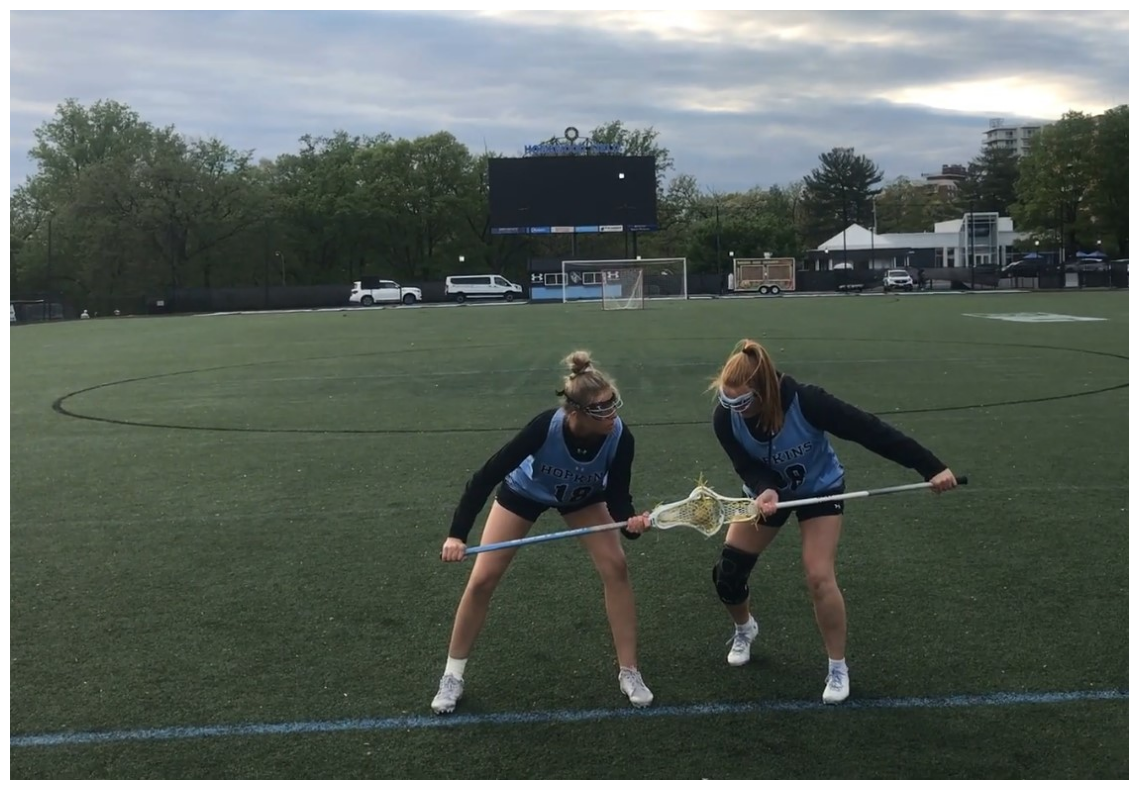

In [20]:
image_view(u)

# Combinig YoloV7 and mPose for 3D Detection

In [23]:
!python detect_copy.py --weights ./yolov7-tiny.pt --conf 0.2 --img-size 640 --source $u

Namespace(agnostic_nms=False, augment=False, classes=None, conf_thres=0.2, device='', exist_ok=False, img_size=640, iou_thres=0.45, name='exp', no_trace=False, nosave=False, project='runs/detect', save_conf=False, save_txt=False, source='C:\\Users\\user/Desktop/CLASSES/Human_pose_estimation_with_YoloV7-main/images/draw.jpg', update=False, view_img=False, weights=['./yolov7-tiny.pt'])
Fusing layers... 
 Convert model to Traced-model... 
 traced_script_module saved! 
 model is traced! 

<class 'torch.Tensor'>
2 persons, 5 cars, 1 tennis racket, Done. (348.6ms) Inference, (16.0ms) NMS
 The image with the result is saved in: runs\detect\exp62\draw.jpg
Done. (0.443s)
[array([        421,         345,         655,         714], dtype=float32), array([        702,         329,         962,         702], dtype=float32)]


YOLOR  v0.1-122-g3b41c2c torch 1.13.1+cpu CPU

Model Summary: 200 layers, 6219709 parameters, 229245 gradients
C:\Users\user\anaconda3\New folder\envs\Stella\lib\site-packages\torch\functional.py:504: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\aten\src\ATen\native\TensorShape.cpp:3191.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


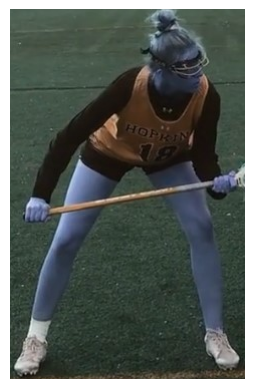

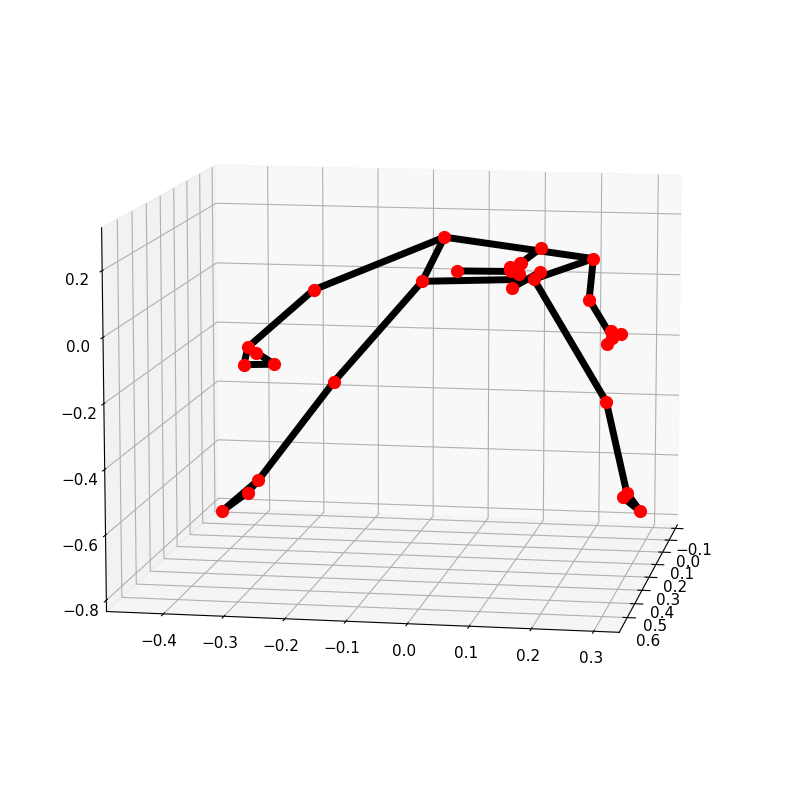

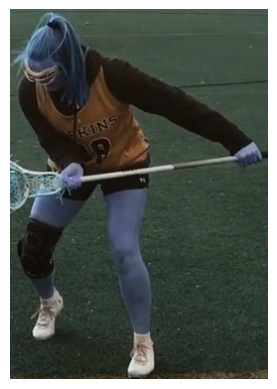

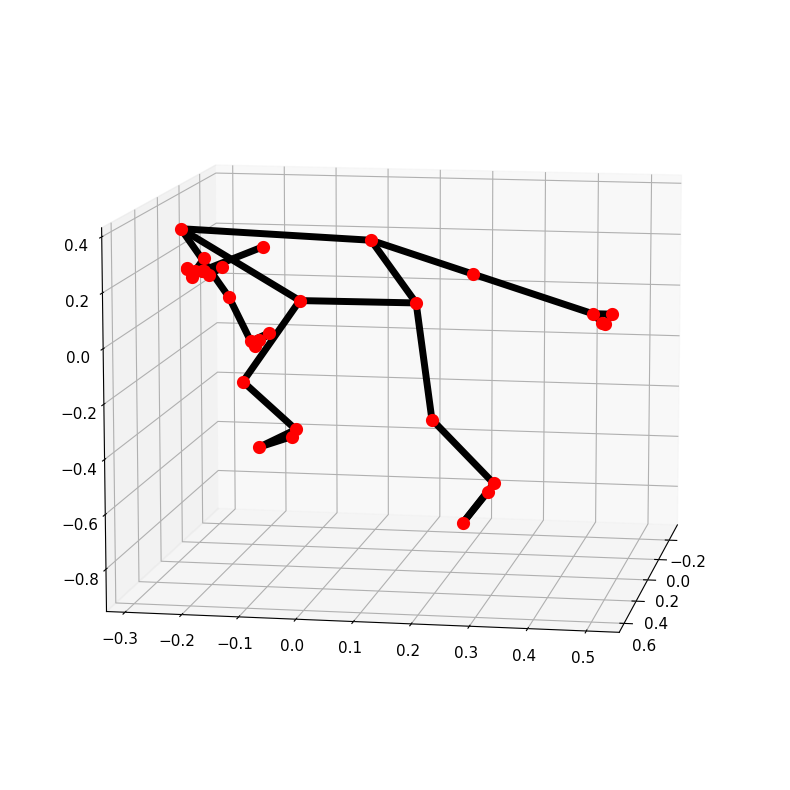

In [21]:
draw_landmarks_pose(u)


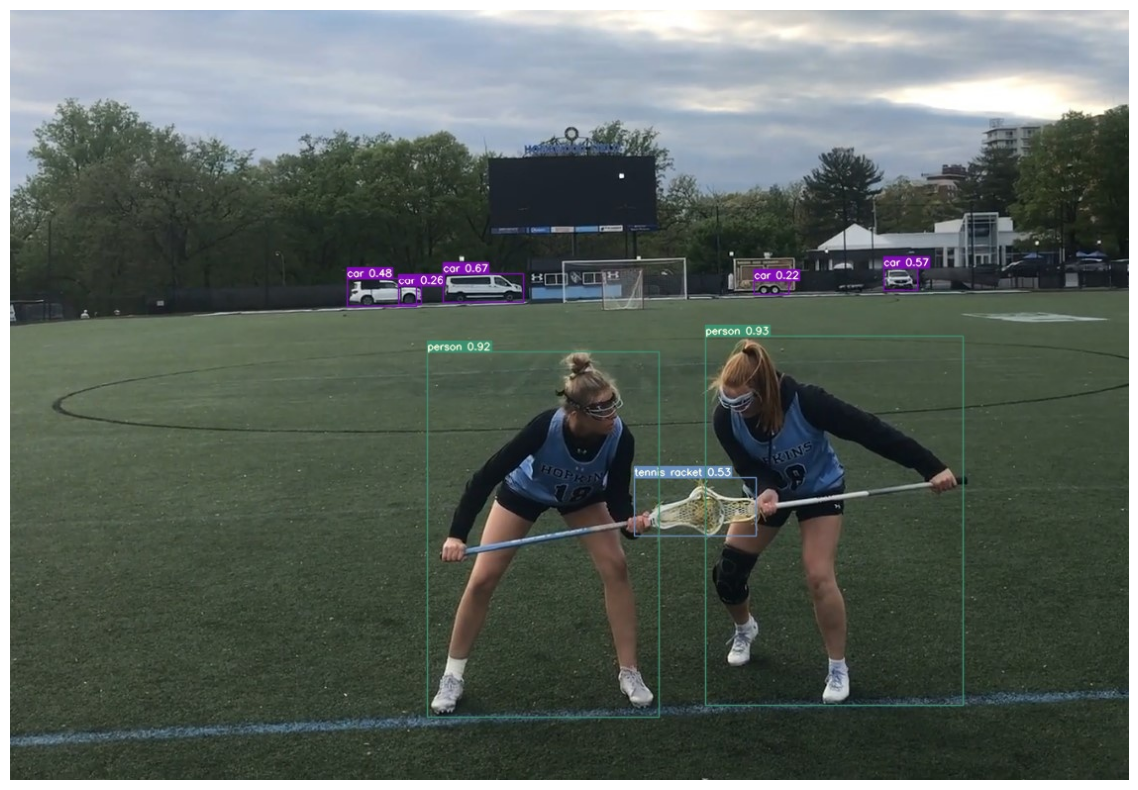

In [68]:
st = "/Desktop/CLASSES/yolov7/runs/detect/exp8/draw.jpg"
direct = str(Path.home()) + st
image_view(direct)



### 3.2 Using the yolov7-w6-pose model

In [63]:
YOLOV7_MODEL[7]

'https://github.com/WongKinYiu/yolov7/releases/download/v0.1/yolov7-w6-pose.pt'

In [64]:
get_yolov7_model(7)

Done

-rw-r--r-- 1 user 197121  13M May 23 16:31 yolov7-tiny.pt
-rw-r--r-- 2 user 197121 154M May 23 16:32 yolov7-w6-pose.pt


In [65]:
YOLOV7MODEL = os.path.basename(YOLOV7_MODEL[7])

try:
    print("Loading the model...")
    model, yolomodel = loading_yolov7_model(yolomodel=YOLOV7MODEL)
    print("Using the", YOLOV7MODEL, "model")
    print("Done")

except:
    print("[Error] Cannot load the model", YOLOV7MODEL)

Loading the model...
Loading model: yolov7-w6-pose.pt
Using the yolov7-w6-pose.pt model
Done


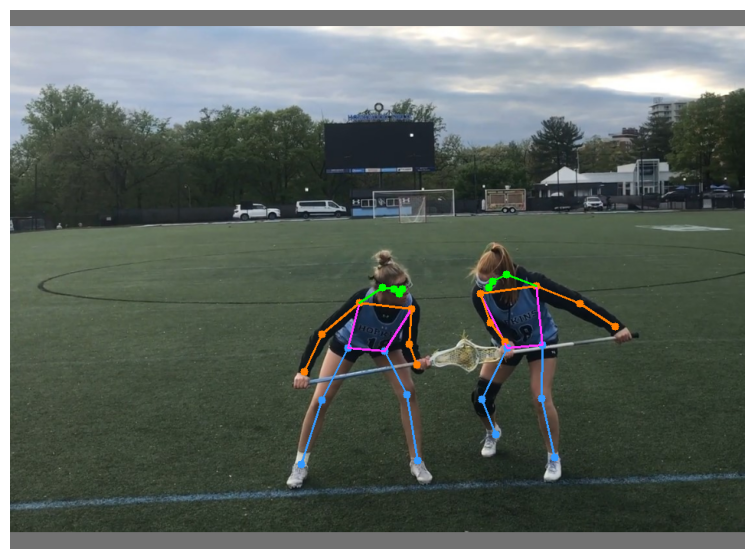

In [66]:
imagefile = "../images/draw.jpg"

output, image = running_inference(cv2.imread(u))
pose_image = draw_keypoints(output, image, confidence=0.25, threshold=0.65)

plt.figure(figsize=(30, 7))
plt.axis("off")
plt.imshow(pose_image)
#plt.scatter(500,500, color = "black")

## 4. Analysing a video with yolov7-w6-pose

In [47]:
def yoloV7_pose_video(videofile, confidence=0.25, threshold=0.65):
    """
    Processing the video using YoloV7
    """
    start = time.time()
    # Reading video
    video = VideoFileClip(videofile)

    # Stats
    duration = video.duration
    fps = round(video.fps)
    nbframes = round(duration * fps)

    print("Processing video:", videofile, "using confidence min =", confidence,
          "and threshold =", threshold)
    print("\nVideo duration =", duration, "seconds")
    print("FPS =", fps)
    print("Total number of frames =", nbframes, "\n")

    # Capture the results frames into a video
    capture = cv2.VideoCapture(videofile)
    fourcc = cv2.VideoWriter_fourcc(*'mp4v')
    outputvideofile = "../results/result_" + os.path.basename(videofile)
    outvideo = cv2.VideoWriter(outputvideofile, fourcc, 30.0,
                               (int(capture.get(3)), int(capture.get(4))))
    idx = 1
    #residual_key_points = []
    
    while capture.isOpened():
        (ret, frame) = capture.read()

        if ret == True:
            if idx % fps == 1:
                nbremainframes = nbframes - idx
                pctdone = round(idx / nbframes * 100)
                print("Processed frames =", f"{idx:06}",
                      "| Number of remaining frames:", f"{nbremainframes:06}",
                      "| Done:", pctdone, "%")
            
            frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
            output, frame = running_inference(frame)
            frame = draw_keypoints(output, frame, confidence, threshold)
            
            #residual_key_points += key_points
            
            #frame = draw_additional(residual_key_points, frame)
            frame = cv2.resize(frame,
                               (int(capture.get(3)), int(capture.get(4))))

            cv2.imwrite(
                "results/videoframe_" + os.path.basename(videofile) + '_' +
                str(f"{idx:06}.jpg"), frame)
            outvideo.write(frame)  # output to video file

        else:
            break

        idx += 1

    processed_time = round(time.time() - start)
    time_per_frame = round(processed_time / (idx - 1), 2)
    print("\nDone in", processed_time, "seconds")
    print("Time per frame =", time_per_frame, "seconds")
    print("\nSaved video:", outputvideofile)

    capture.release()
    outvideo.release()

    return outputvideofile

### 4.1 Test 1

In [48]:
dir = "/Desktop/CLASSES/Human_pose_estimation_with_YoloV7-main/videos/draws3.mp4"

In [49]:
from pathlib import Path
u = str(Path.home()) + dir

In [50]:
#football_vid = "../videos/football.mp4"
football_video = yoloV7_pose_video(u)

Processing video: C:\Users\user/Desktop/CLASSES/Human_pose_estimation_with_YoloV7-main/videos/draws3.mp4 using confidence min = 0.25 and threshold = 0.65

Video duration = 5.11 seconds
FPS = 30
Total number of frames = 153 

Processed frames = 000001 | Number of remaining frames: 000152 | Done: 1 %


AttributeError: 'Upsample' object has no attribute 'recompute_scale_factor'

In [ ]:
VideoFileClip(football_video).ipython_display(width=640)